Install the Librosa, Keras, TesnorFlow and sound packages

In [83]:
import sys
!{sys.executable} -m pip install librosa

In [10]:
import sys
!{sys.executable} -m pip install keras

In [11]:
import sys
!{sys.executable} -m pip install --user tensorflow

In [25]:
import sys
!{sys.executable} -m pip install sounddevice

In [26]:
import sys
!{sys.executable} -m pip install soundfile

Import the following packages

In [84]:
import librosa   
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython.display as pyDisp


Reading the Audio Signal for word left in Time-Series Domain and viuslaizing the wave

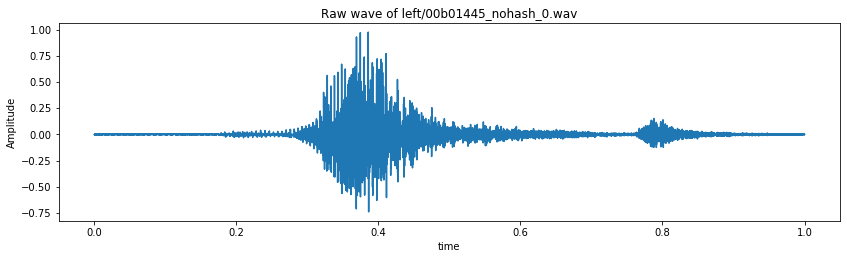

In [85]:
audioPath = 'tensorflow-speech-recognition-challenge/train/audio/'
samples, sample_rate = librosa.load(audioPath +'left wave')
fig = plt.figure(figsize=(14, 8))
axis = fig.add_subplot(211)
axis.set_title('Raw wave of ' + 'left/00b01445_nohash_0.wav')
axis.set_xlabel('time')
axis.set_ylabel('Amplitude')
axis.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

Checking the sample rate of the input signal

In [86]:
pyDisp.Audio(samples, rate=sample_rate)
print("Sampling rate of input wave:  ",sample_rate)

Sampling rate of input wave:   22050


Changing the sampling rate of audio signal to 8000 Hz

In [5]:
samples = librosa.resample(samples, sample_rate, 8000)
pyDisp.Audio(samples, rate=8000)

Counting the number of audio files for each speech command and plotting the frequency in form of bar plot

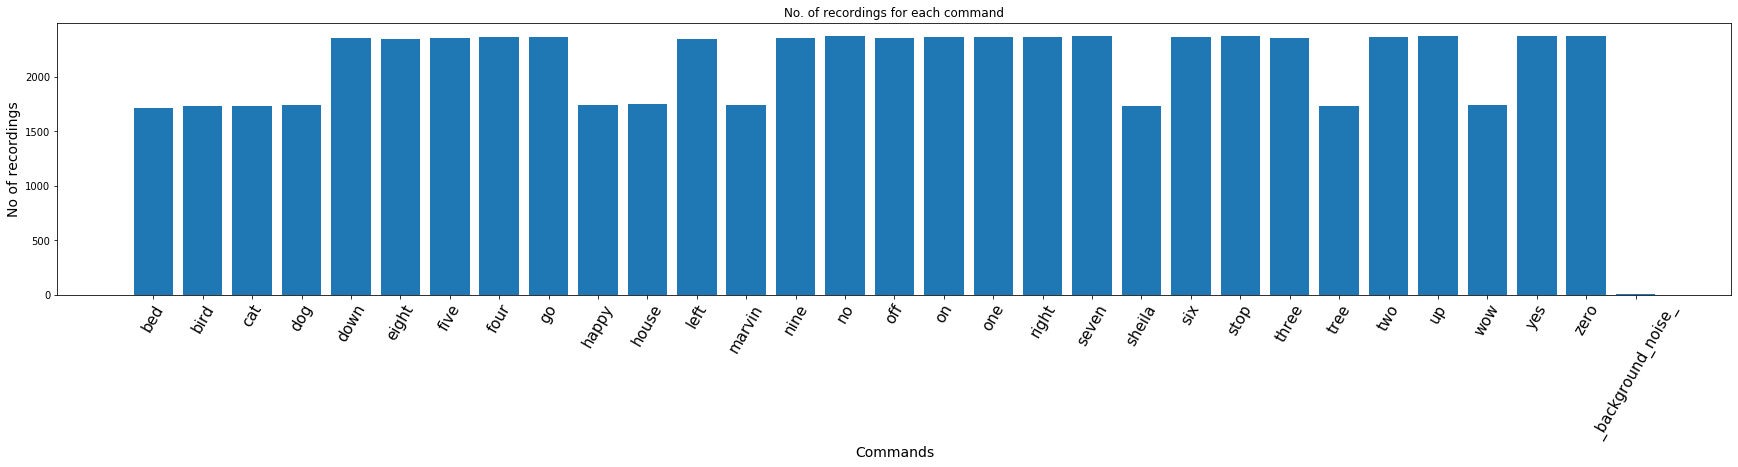

In [76]:
labels=os.listdir(audioPath)
recordings=[]
for label in labels:
    waves = [iterate for iterate in os.listdir(audioPath + '/'+ label) if iterate.endswith('.wav')]
    recordings.append(len(waves))
    
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, recordings)
plt.xlabel('Commands', fontsize=14)
plt.ylabel('No of recordings', fontsize=14)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

# labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

Plotting the time distribution of the audio files from dataset

Text(0.5, 1.0, 'Time Distribution of audio waves')

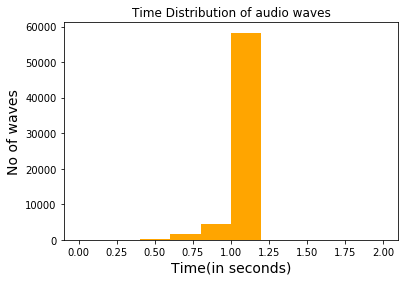

In [77]:
drecordings=[]
for label in labels:
    waves = [f for f in os.listdir(audioPath + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(audioPath + '/' + label + '/' + wav)
        drecordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(drecordings),range=[0, 2], facecolor='orange')
plt.xlabel('Time(in seconds)', fontsize=14)
plt.ylabel('No of waves', fontsize=14)
plt.title('Time Distribution of audio waves')

Removing the audio files of duration less than one second

In [8]:
every_wave = []
each_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir('tensorflow-speech-recognition-challenge/train/audio/' + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load('tensorflow-speech-recognition-challenge/train/audio/' + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            every_wave.append(samples)
            each_label.append(label)

bed
bird
cat
dog
down
eight
five
four
go
happy
house
left
marvin
nine
no
off
on
one
right
seven
sheila
six
stop
three
tree
two
up
wow
yes
zero
_background_noise_


Encoding the labels using one-hot encoding 

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(labels))

In [13]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [14]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

Building the model

In [15]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

In [16]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 

In [18]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Train on 46601 samples, validate on 11651 samples
Epoch 1/100
46601/46601 [==============================] - 226s 5ms/step - loss: 2.8840 - accuracy: 0.1461 - val_loss: 2.0685 - val_accuracy: 0.3773
Epoch 2/100
46601/46601 [==============================] - 233s 5ms/step - loss: 1.8683 - accuracy: 0.4199 - val_loss: 1.3805 - val_accuracy: 0.5842
Epoch 3/100
46601/46601 [==============================] - 229s 5ms/step - loss: 1.4932 - accuracy: 0.5422 - val_loss: 1.1892 - val_accuracy: 0.6465
Epoch 4/100
46601/46601 [==============================] - 232s 5ms/step - loss: 1.3252 - accuracy: 0.5983 - val_loss: 1.1045 - val_accuracy: 0.6666
Epoch 5/100
46601/46601 [==============================] - 228s 5ms/step - loss: 1.2165 - accuracy: 0.6282 - val_loss: 0.9698 - val_accuracy: 0.7134
Epoch 6/100
46601/46601 [==============================] - 233s 5ms/step - loss: 1.1211 - accuracy: 0.6577 - val_loss: 0.8556 - val_accuracy: 0.7430
Epoch 7/100
46601/46601 [==============================]

Plotting the Loss for with every epochs

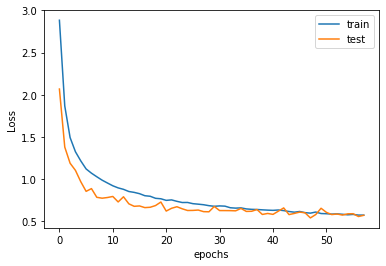

In [79]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.ylabel("Loss")
pyplot.xlabel("epochs")
pyplot.legend() 
pyplot.show()

Predict function 

In [22]:
def predict(audio):
    prob = model.predict(audio.reshape(1,8000,1))
    index = np.argmax(prob[0])
    return classes[index]

In [23]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
pyDisp.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: six
Text: six


Record your own test command

In [73]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'testCommand.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


Predicting the output for recorded command

In [74]:
samples, sample_rate = librosa.load('testCommand.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
pyDisp.Audio(samples,rate=8000)  

predict(samples)

'happy'